In [20]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras

from emnist import list_datasets, extract_training_samples, extract_test_samples

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1. Load data

In [2]:
print(list_datasets())
tipus = "balanced"

X_full_train, y_full_train = extract_training_samples(tipus)
X_test, y_test = extract_test_samples(tipus)

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size = 0.1, random_state = 123)
# del X_full_train, y_full_train # Free memory

# 2. PCA per veure si es va més ràpid a modelar

In [4]:
def flatten(data, dim_img = (28, 28)):
    return data.reshape(len(data), dim_img[0] * dim_img[1])

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
X_train_PCA = pca.fit_transform(flatten(X_train))
X_val_PCA = pca.transform(flatten(X_val))
X_test_PCA = pca.transform(flatten(X_test))
print(X_train_PCA.shape)

(101520, 113)


# 3. Modeling

## Models:

Esta trigant molt perque hi ha moltes classes, gran n i gran k. Pensar en reduïr la dimenció amb PCA.

- SGD (Stochastic Gradient Descent classifier): tarda molt, deixar-ho per mes endavant
- Softmax regression TODO
- SVC
- Random Forest
- ANN
- CNN

## SGD C

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

sgd = make_pipeline(StandardScaler(), 
                    SGDClassifier(max_iter = 1000, tol = 5e-3, random_state = 123))
sgd.fit(X_train_PCA[:5000], y_train[:5000])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(random_state=123, tol=0.005))])

In [18]:
y_predict = sgd.predict(X_train_PCA[:5000])
print("Accuracy = ", accuracy_score(y_train[:5000], y_predict))
y_val_predict = sgd.predict(X_val_PCA)
print("Accuracy validation = ", accuracy_score(y_val, y_val_predict))

Accuracy =  0.7668
Accuracy validation =  0.5140070921985815


## SVC

En svc lineal, sembla que reduir amb pca tarda més, per tant no reduïr de moment. Sembla que escalant tampoc millora. Els models tarden molt a estimar-se (> 1h). Millor utilitzar una mostra reduïda de moment.

Lineal:

In [53]:
from sklearn.svm import LinearSVC

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(flatten(X_train))
X_val_scaled = scaler.transform(flatten(X_val))

svc_lin = LinearSVC(random_state = 123)
svc_lin.fit(flatten(X_train_scaled), y_train)

d:\Estudi\Uni\Actual\TFG\Github\.venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(random_state=123)

In [55]:
y_val_predict = svc_lin.predict(flatten(X_val))
print("Accuracy = ", accuracy_score(y_val, y_val_predict))

Accuracy =  0.38067375886524824


SVC gaussian RBF kernel:

In [7]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(flatten(X_train))
X_val_scaled = scaler.transform(flatten(X_val))

svc_rbf = SVC(gamma = "scale")
svc_rbf.fit(X_train_scaled[:10000], y_train[:10000])

SVC()

In [13]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

y_train_predict = svc_rbf.predict(X_train_scaled[:10000])
print("Accuracy = ", accuracy_score(y_train[:10000], y_train_predict))

Accuracy =  0.8927


In [40]:
# Fine tune hyperparameters

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_dist = {"gamma" : reciprocal(0.0005, 0.01), "C" : uniform(2, 15)}
rnd_search_cv = RandomizedSearchCV(svc_rbf, param_dist, n_iter = 20, verbose = 1, cv = 3)
rnd_search_cv.fit(X_train_scaled[:10000], y_train[:10000])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024E33D3A8E0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024E33D3E130>},
                   verbose=1)

In [41]:
print(rnd_search_cv.best_estimator_)
print(rnd_search_cv.best_score_)

SVC(C=7.640523694841579, gamma=0.0006875034827494735)
0.7318997346645283


In [53]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=7.640523694841579, gamma=0.0006875034827494735)

In [57]:
y_train_predict = svc_rbf.predict(X_train_scaled)
print("Accuracy = ", accuracy_score(y_train, y_train_predict))

Accuracy =  0.7445232466509062


0.7357269503546099


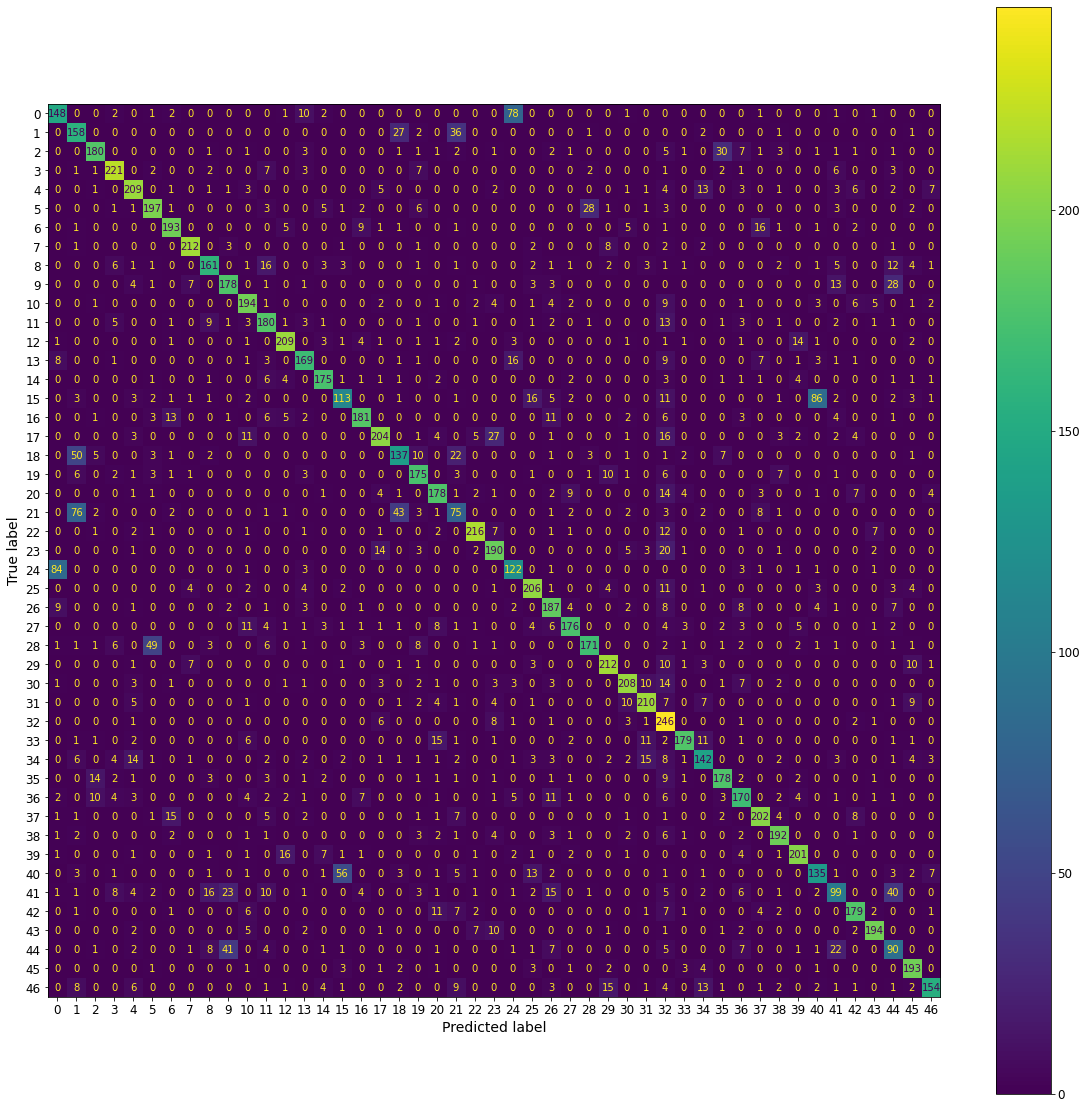

In [61]:
y_val_pred = svc_rbf.predict(X_val_scaled)
print(accuracy_score(y_val, y_val_pred))

fig, ax = plt.subplots(figsize = (20, 20))
plot_confusion_matrix(svc_rbf, X_val_scaled, y_val, ax = ax)
plt.show()

# Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

rnd_forest = RandomForestClassifier(n_estimators = 100, random_state = 123)
rnd_forest.fit(flatten(X_train), y_train)

RandomForestClassifier(random_state=123)

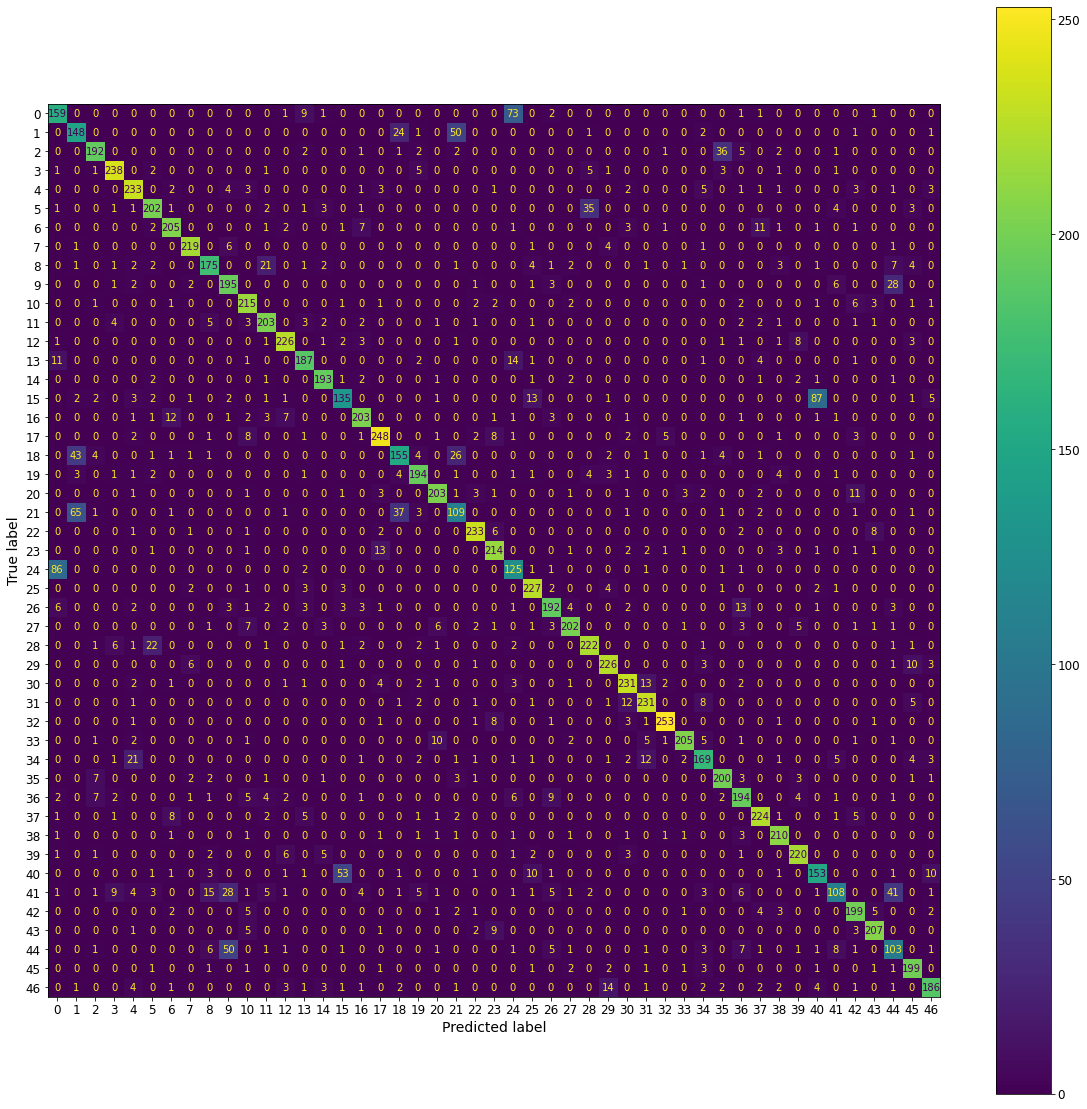

In [61]:
y_val_pred = rnd_forest.predict(flatten(X_val))
print(accuracy_score(y_val, y_val_pred))

fig, ax = plt.subplots(figsize = (20, 20))
plot_confusion_matrix(rnd_forest, flatten(X_val), y_val, ax = ax)
plt.show()

# MLP

In [5]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
k = len(np.unique(y_train))

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(500, activation = "relu"))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(k, activation = "softmax")) # Classes exclusives

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               150300    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_4 (Dense)              (None, 47)                4747      
Total params: 667,947
Trainable params: 667,947
Non-trainable params: 0
__________________________________________________

In [8]:
model.compile(loss = "sparse_categorical_crossentropy", # keras.losses.sparse_categorical_crossentropy
              optimizer = keras.optimizers.SGD(),
              metrics = ["accuracy"]) 

In [9]:
history = model.fit(X_train / 255, y_train, epochs = 30, validation_data = (X_val / 255, y_val))

Epoch 1/30
19630/19630 [==============================] - 137s 7ms/step - loss: 0.7643 - accuracy: 0.7713 - val_loss: 0.4790 - val_accuracy: 0.8431
Epoch 2/30
19630/19630 [==============================] - 124s 6ms/step - loss: 0.4351 - accuracy: 0.8537 - val_loss: 0.4235 - val_accuracy: 0.8541
Epoch 3/30
19630/19630 [==============================] - 121s 6ms/step - loss: 0.3787 - accuracy: 0.8694 - val_loss: 0.3720 - val_accuracy: 0.8717
Epoch 4/30
19630/19630 [==============================] - 119s 6ms/step - loss: 0.3487 - accuracy: 0.8777 - val_loss: 0.3652 - val_accuracy: 0.8714
Epoch 5/30
19630/19630 [==============================] - 121s 6ms/step - loss: 0.3291 - accuracy: 0.8831 - val_loss: 0.3444 - val_accuracy: 0.8769
Epoch 6/30
19630/19630 [==============================] - 119s 6ms/step - loss: 0.3143 - accuracy: 0.8872 - val_loss: 0.3308 - val_accuracy: 0.8824
Epoch 7/30
19630/19630 [==============================] - 121s 6ms/step - loss: 0.3026 - accuracy: 0.8903 - val_

# CNN

Fer una cnn més complicada, perque sembla que estic underfitting

In [37]:
X_train = X_train[..., np.newaxis] / 255
X_val = X_val[..., np.newaxis] / 255
X_test = X_test[..., np.newaxis] / 255

In [45]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size = 3, padding = "same", activation = "relu"),
    keras.layers.Conv2D(64, kernel_size = 3, padding = "same", activation = "relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(np.unique(y_train)), activation = "softmax")
])
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
model.fit(X_train, y_train, epochs = 1, validation_data = (X_val, y_val))
model.evaluate(X_test, y_test)

588/588 [==============================] - 7s 11ms/step - loss: 0.5009 - accuracy: 0.8325


[0.500901997089386, 0.8324999809265137]

In [46]:
model.fit(X_train, y_train, epochs = 5, validation_data = (X_val, y_val))
model.evaluate(X_test, y_test)

Epoch 1/5
3173/3173 [==============================] - 364s 115ms/step - loss: 0.6629 - accuracy: 0.7845 - val_loss: 0.4106 - val_accuracy: 0.8543
Epoch 2/5
3173/3173 [==============================] - 334s 105ms/step - loss: 0.5781 - accuracy: 0.8064 - val_loss: 0.3748 - val_accuracy: 0.8668
Epoch 3/5
3173/3173 [==============================] - 435s 137ms/step - loss: 0.5276 - accuracy: 0.8243 - val_loss: 0.3613 - val_accuracy: 0.8722
Epoch 4/5
3173/3173 [==============================] - 421s 133ms/step - loss: 0.4923 - accuracy: 0.8323 - val_loss: 0.3552 - val_accuracy: 0.8736
Epoch 5/5
588/588 [==============================] - 10s 17ms/step - loss: 0.3927 - accuracy: 0.8686


[0.39273035526275635, 0.8685638308525085]

# 4. Avaluation

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

X_val_red = pca.transform(flatten(X_val))
y_val_predict = sgd.predict(X_val_red)
print("Accuracy = ", accuracy_score(y_val, y_val_predict))

conf_matrx = confusion_matrix(y_val, y_val_predict)
conf_matrx

Accuracy =  0.5898049645390071


array([[ 89,   0,   0, ...,   0,   0,   0],
       [  0, 110,   0, ...,   5,   0,   5],
       [  0,   0, 148, ...,   3,   0,   0],
       ...,
       [  0,   0,   0, ...,  85,   0,   2],
       [  0,   0,   0, ...,   2, 144,   6],
       [  1,   0,   0, ...,  11,   4, 128]], dtype=int64)

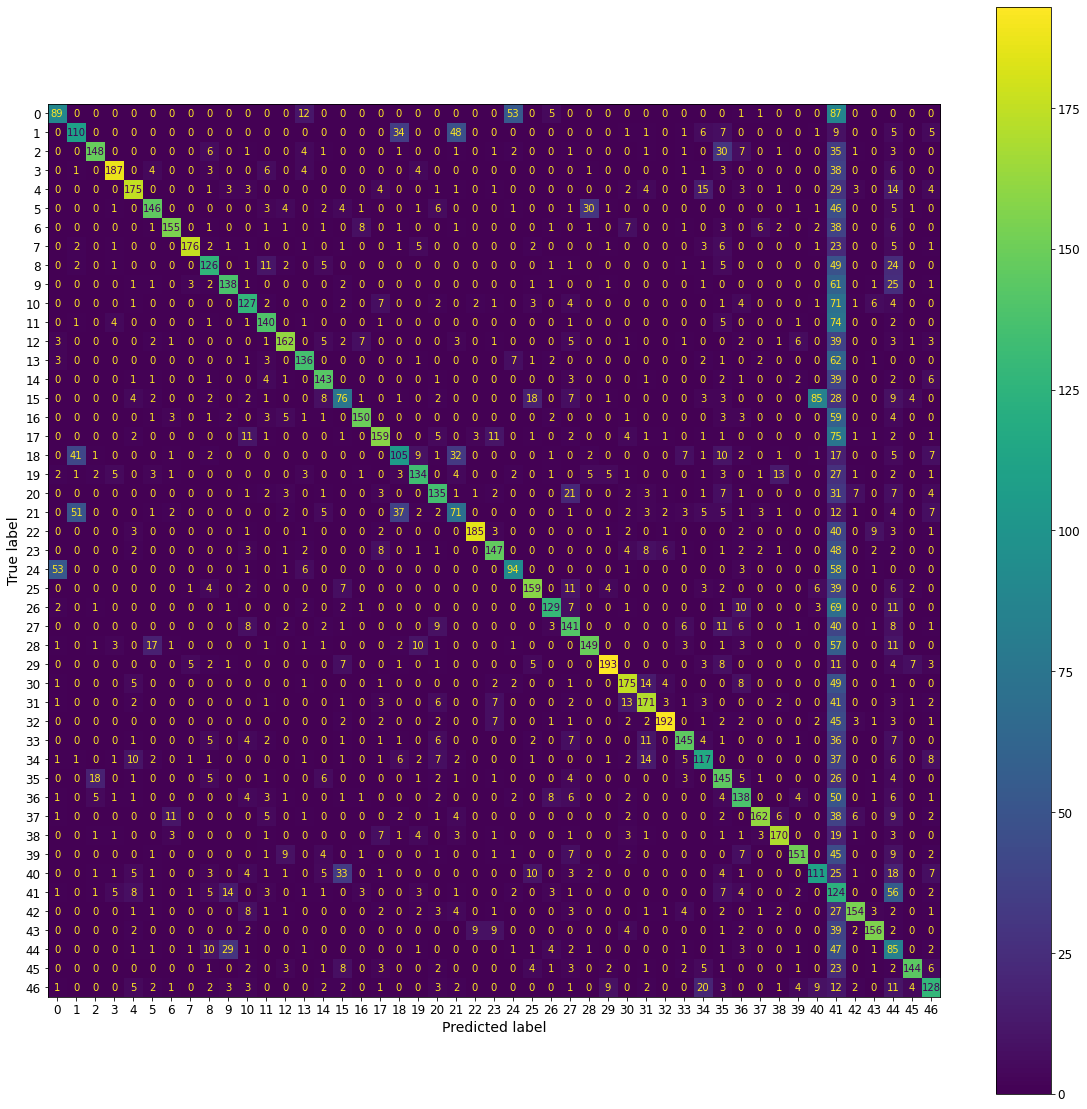

In [37]:
fig, ax = plt.subplots(figsize = (20, 20))
plot_confusion_matrix(sgd, X_val_red, y_val, ax = ax)
plt.show()

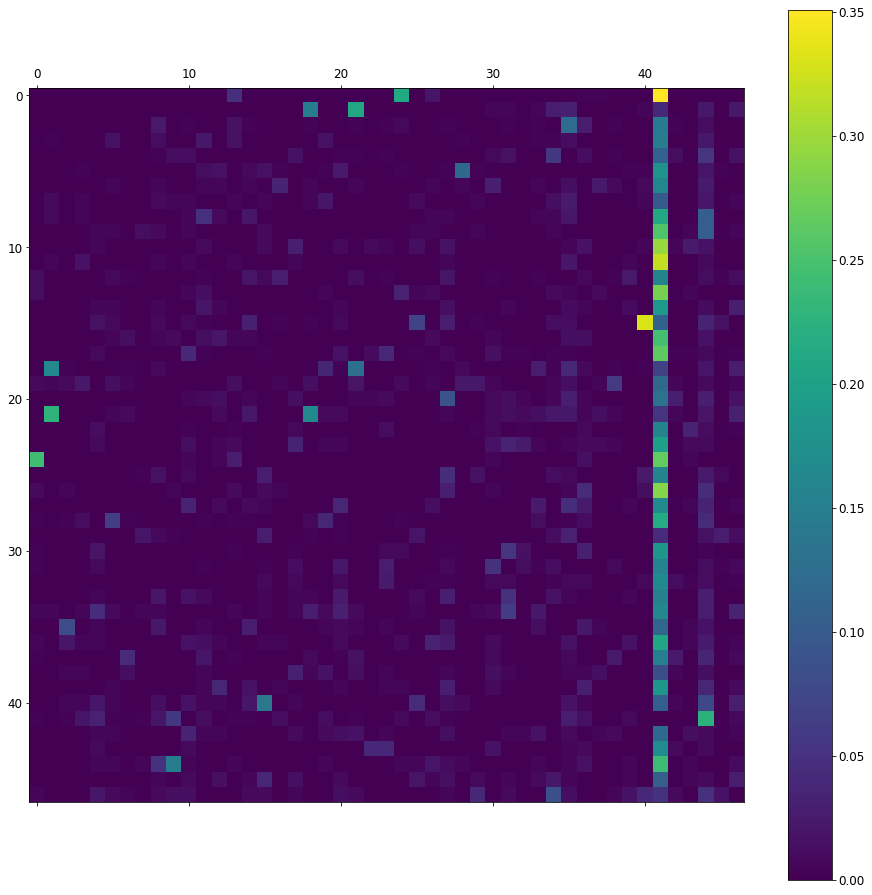

In [38]:
def plot_conf(matrix, figsize = (16, 16)):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

row_sums = conf_matrx.sum(axis = 1, keepdims = True)
norm_conf_matrx = conf_matrx / row_sums
np.fill_diagonal(norm_conf_matrx, 0)
plot_conf(norm_conf_matrx)

- SVM C